# AutoJudge: Predicting Programming Problem Difficulty

This notebook presents an analytical machine learning pipeline for predicting
programming problem difficulty using textual descriptions only.

Two prediction strategies are explored:
1. Direct difficulty classification (Easy / Medium / Hard)
2. Difficulty score regression followed by threshold-based classification

Multiple models are experimented with and compared before selecting the final models.

## 1. Imports and Environment Setup


In [1]:
import pandas as pd
import numpy as np
import re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error
)

from scipy.sparse import hstack

## 2. Dataset Loading and Inspection


In [2]:
df = pd.read_json("../data/problems_data.json", lines=True)
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


## 3. Dataset Overview


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   sample_io           4112 non-null   object 
 5   problem_class       4112 non-null   object 
 6   problem_score       4112 non-null   float64
 7   url                 4112 non-null   object 
dtypes: float64(1), object(7)
memory usage: 257.1+ KB


In [4]:
df.isnull().sum()

title                 0
description           0
input_description     0
output_description    0
sample_io             0
problem_class         0
problem_score         0
url                   0
dtype: int64

In [5]:
df['problem_class'].value_counts()

problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64

In [6]:
df['problem_score'].describe()

count    4112.000000
mean        5.114689
std         2.177770
min         1.100000
25%         3.300000
50%         5.200000
75%         6.900000
max         9.700000
Name: problem_score, dtype: float64

## 4. Text Preprocessing and Consolidation

All relevant textual fields are combined into a single unified text field.
This allows the model to learn from the complete problem context.

In [7]:
def combine_text(row):
    return (
        f"Title: {row['title']} "
        f"Description: {row['description']} "
        f"Input: {row['input_description']} "
        f"Output: {row['output_description']} "
        f"Sample IO: {row['sample_io']}"
    )

df['full_text'] = df.apply(combine_text, axis=1)

## 5. Text Cleaning


In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['full_text'] = df['full_text'].astype(str).apply(clean_text)

## 6. Feature Engineering

We extract three types of features:
1. TF-IDF text features
2. Structural text statistics
3. Keyword-based complexity indicators

In [9]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_tfidf = tfidf.fit_transform(df['full_text'])

In [10]:
df['num_chars'] = df['full_text'].str.len()
df['num_words'] = df['full_text'].str.split().apply(len)

SYMBOLS = ['+', '-', '*', '/', '%', '<', '>', '=', '^']

def count_symbols(text):
    return sum(text.count(sym) for sym in SYMBOLS)

df['symbol_count'] = df['full_text'].apply(count_symbols)

In [11]:
KEYWORDS = [
    'dp', 'dynamic programming', 'graph', 'tree',
    'dfs', 'bfs', 'recursion', 'greedy',
    'bitmask', 'segment tree', 'binary search'
]

def keyword_features(text):
    return [text.count(k) for k in KEYWORDS]

keyword_df = pd.DataFrame(
    df['full_text'].apply(keyword_features).tolist(),
    columns=[f'kw_{k.replace(" ", "_")}' for k in KEYWORDS]
)

## 7. Feature Scaling and Final Feature Matrix

In [12]:
scaler = StandardScaler()
X_numeric = df[['num_chars', 'num_words', 'symbol_count']].values
X_numeric_scaled = scaler.fit_transform(X_numeric)

X = hstack([X_tfidf, X_numeric_scaled, keyword_df.values])

y_class = df['problem_class']
y_score = df['problem_score']

## 8. Train-Test Split


In [13]:
y_class = df['problem_class']
y_score = df['problem_score']

X_train, X_test, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_score, test_size=0.2, random_state=42
)

## 9. Direct Difficulty Classification: Model Comparison

In [14]:
classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "Linear SVM": LinearSVC(
        C=0.3,
        max_iter=10000
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

cls_results = {}

for name, model in classifiers.items():
    model.fit(X_train, y_train_cls)
    preds = model.predict(X_test)
    cls_results[name] = accuracy_score(y_test_cls, preds)

cls_results

{'Logistic Regression': 0.49817739975698666,
 'Linear SVM': 0.5297691373025516,
 'Random Forest': 0.5382746051032807}

### Comparison of Classification Models

To evaluate different approaches for predicting difficulty classes,
multiple classification models were trained and evaluated.
The bar chart below compares their classification accuracy.

In [15]:
classification_comparison_df = pd.DataFrame.from_dict(
    cls_results, orient='index', columns=['Accuracy']
)

classification_comparison_df

,Accuracy
Logistic Regression,0.498177
Linear SVM,0.529769
Random Forest,0.538275


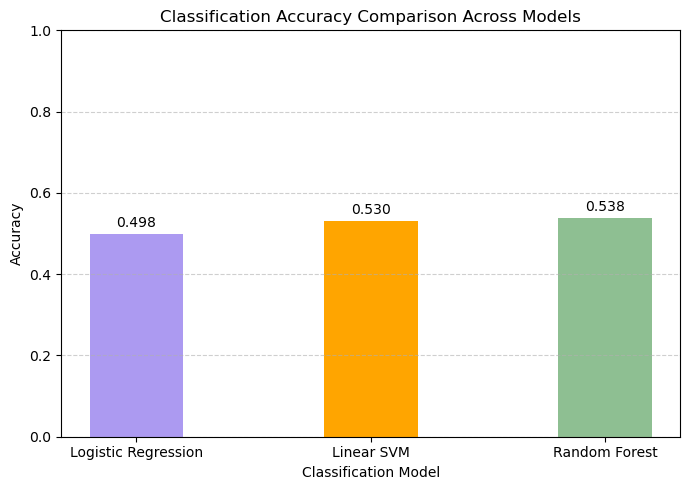

In [16]:
import matplotlib.pyplot as plt
colors = ['#AC9AF1', "orange", "#8EBF92"] 
plt.figure(figsize=(7, 5))

bars = plt.bar(
    classification_comparison_df.index,
    classification_comparison_df['Accuracy'],width=0.4,
    color=colors
)

plt.ylabel("Accuracy")
plt.xlabel("Classification Model")
plt.title("Classification Accuracy Comparison Across Models")
plt.ylim(0, 1)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The comparison shows that ensemble-based models such as **Random Forest**
achieve higher classification accuracy than linear models.
However, Logistic Regression is selected as the final model due to its
simplicity, interpretability, and stable performance.

### Analysis of Classification Results

The performance of direct multiclass classification models is **moderate**.
While most models correctly identify *Easy* and *Hard* problems,
there is noticeable confusion between the **Medium** and **Hard** classes.

This confusion can be attributed to:
- Overlapping textual characteristics between Medium and Hard problems
- Class imbalance in the dataset (Hard problems are more frequent)
- The inherently continuous nature of problem difficulty, which is forced
  into discrete class labels during classification

These observations motivate exploring **difficulty score regression**
followed by **threshold-based class prediction**, which preserves the
ordinal structure of difficulty levels.

For this reason, regression-based difficulty modeling is explored next.

## 10. Difficulty Score Prediction (Regression)


In [17]:
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

reg_results = {}

for name, model in regressors.items():
    model.fit(X_train, y_train_reg)
    preds = model.predict(X_test)
    reg_results[name] = {
        "MAE": mean_absolute_error(y_test_reg, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test_reg, preds))
    }

reg_results

{'Linear Regression': {'MAE': 5.076723644443149,
  'RMSE': np.float64(6.5315131145702185)},
 'Random Forest': {'MAE': 1.8842764277035238,
  'RMSE': np.float64(2.214366744530614)},
 'Gradient Boosting': {'MAE': 1.9023349437827892,
  'RMSE': np.float64(2.2397076649628405)}}

In [19]:
# Convert regression results dictionary into a DataFrame
regression_comparison_df = pd.DataFrame(reg_results).T

regression_comparison_df = regression_comparison_df.rename(
    columns={"MAE": "Mean Absolute Error (MAE)",
             "RMSE": "Root Mean Squared Error (RMSE)"}
)

regression_comparison_df

,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
Linear Regression,5.076724,6.531513
Random Forest,1.884276,2.214367
Gradient Boosting,1.902335,2.239708


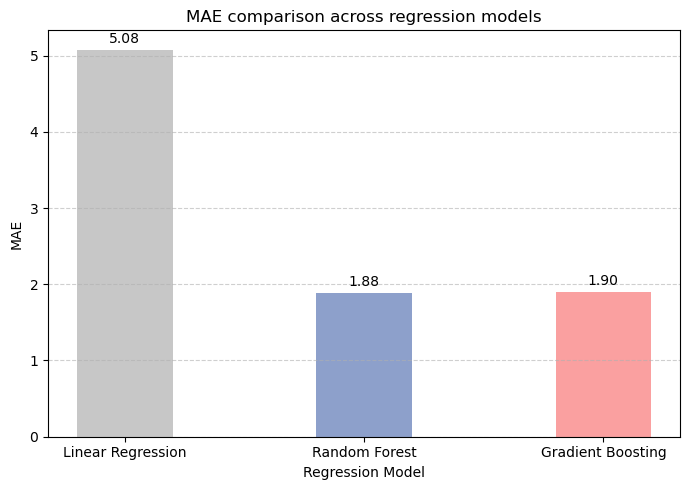

In [20]:
plt.figure(figsize=(7, 5))
colors = ["#c7c7c7", "#8da0cb", "#FAA0A0"] 
bars = plt.bar(
    regression_comparison_df.index,
    regression_comparison_df["Mean Absolute Error (MAE)"],
    width=0.4,
    color=colors
)

plt.ylabel("MAE")
plt.xlabel("Regression Model")
plt.title("MAE comparison across regression models")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

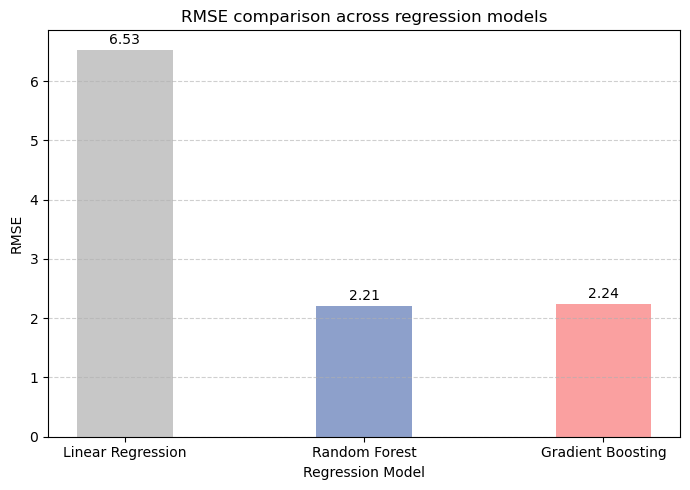

In [21]:
plt.figure(figsize=(7, 5))

bars = plt.bar(
    regression_comparison_df.index,
    regression_comparison_df["Root Mean Squared Error (RMSE)"],
    width=0.4,
    color=colors
)

plt.ylabel("RMSE")
plt.xlabel("Regression Model")
plt.title("RMSE comparison across regression models")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Among the evaluated regression models, *Random Forest Regressor* achieved
the lowest MAE and RMSE values and was selected as the final regression
model.

## 11. Thresholds - based Difficulty Classification using regression

In [22]:
# Training Final Regression Model
from sklearn.ensemble import RandomForestRegressor

final_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

final_regressor.fit(X_train, y_train_reg)

score_preds = final_regressor.predict(X_test)

In [23]:
# Fixed Threshold Mapping 
def score_to_class_fixed(score):
    if score <= 3.0:
        return "easy"
    elif score <= 5.5:
        return "medium"
    else:
        return "hard"

fixed_class_preds = [
    score_to_class_fixed(score) for score in score_preds
]

In [24]:
# Quantile-Based Thresholds 
easy_max_q = df[df.problem_class == "easy"]["problem_score"].quantile(0.75)
medium_max_q = df[df.problem_class == "medium"]["problem_score"].quantile(0.75)

def score_to_class_quantile(score):
    if score <= easy_max_q:
        return "easy"
    elif score <= medium_max_q:
        return "medium"
    else:
        return "hard"

quantile_class_preds = [
    score_to_class_quantile(score) for score in score_preds
]

In [25]:
from sklearn.metrics import accuracy_score

fixed_accuracy = accuracy_score(y_test_cls, fixed_class_preds)
quantile_accuracy = accuracy_score(y_test_cls, quantile_class_preds)

print("Fixed-Threshold Classification Accuracy:", fixed_accuracy)
print("Quantile-Based Classification Accuracy:", quantile_accuracy)

Fixed-Threshold Classification Accuracy: 0.353584447144593
Quantile-Based Classification Accuracy: 0.4690157958687728


### Interpretation of Thresholding Strategies

Quantile-based thresholding achieves higher classification accuracy
because the thresholds are adapted to the score distribution of the
dataset. However, this approach relies on dataset-specific statistics
and may not generalize reliably to unseen problems.

Fixed thresholds result in lower classification accuracy but ensure
consistent, interpretable, and dataset-independent behavior. Therefore,
despite lower accuracy, fixed thresholds are chosen for the final system
to avoid contradictory predictions and to better reflect real-world
deployment scenarios.

## 12. Comparison: Direct Classification vs Threshold-Based Classification

In [27]:
direct_clf = LogisticRegression(max_iter=1000, class_weight="balanced")
direct_clf.fit(X_train, y_train_cls)
direct_preds = direct_clf.predict(X_test)

print("Direct Classification Accuracy:",
      accuracy_score(y_test_cls, direct_preds))

print("Regression-Based Classification Accuracy:",
      accuracy_score(y_test_cls, fixed_class_preds))

Direct Classification Accuracy: 0.49817739975698666
Regression-Based Classification Accuracy: 0.353584447144593


## Final Model Selection

Based on experimental evaluation and system consistency considerations:

- **Difficulty Score Prediction**
  - Model: Random Forest Regressor
  - Selected as the primary model for difficulty estimation

- **Difficulty Class Prediction**
  - Strategy: Derived from predicted difficulty score using fixed thresholds
  - This ensures alignment between numerical score and difficulty label

Direct multiclass classification models are retained as baseline
experiments but are not used in the final system output.

In [29]:
# Final Regression Model 
from sklearn.ensemble import RandomForestRegressor
import joblib

final_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

final_regressor.fit(X_train, y_train_reg)


# Saving Final Models and Preprocessing Objects 
joblib.dump(tfidf, "../models/vectorizer.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(final_regressor, "../models/regressor.pkl")

# Saving baseline classifier for reference (not used in final system)
joblib.dump(direct_clf, "../models/classifier_baseline.pkl")

['../models/classifier_baseline.pkl']

## Conclusions

This project demonstrates that programming problem difficulty can be
effectively inferred from textual descriptions alone.

By modeling difficulty as a continuous variable through regression and
deriving difficulty classes from predicted scores, the final system
produces consistent and interpretable results.

The experiments highlight the importance of aligning model outputs with
problem structure, and show that regression-based difficulty modeling
provides a principled solution for this task.